### Time Series Analysis
In this notebook I aim to cover some time series analysis techniques, including extracting trends, seasonal and noise patterns, forecasting, ARMA and ARCH models, Fourier transforms, and digital signal synthesis. I will use two example datasets. One is the cadairydata provided with the Microsoft course DAT203.3x available here :

https://courses.edx.org/courses/course-v1:Microsoft+DAT203.3x+2T2017/course/

The other data will be an audio recording of a note on an acoustic guitar.

Both data should exhibit periodic behaviour, which will be useful. 

To read and manipulate the audio signal I will use the ThinkDSP libraries, available here

https://github.com/AllenDowney/ThinkDSP

#### Dairy Data
This first data set contains various dairy production data. The first few tasks will follow the exercises in the Microsoft DAT203.3x course, though I have converted the work from R to Python primarily via the statsmodels and pyramid-arima libraries.

The first task is to read in the data, for which we will use Pandas. We will convert the dates in the dataset to a standard datetime format so that Pandas understands how to order them, and so that the date can be used as an index column. To do this we simply fix the day as the 1st of the month, as the day is not provided. The read_data function below can in principle be used for different files, though they would need to be in a similar format to cadairydata.csv.

In [142]:
import numpy as np
import pandas as pd

def read_data(filename):
    df = pd.read_csv(filename + ".csv", index_col = 0)
    # convert dates to date time and use as index
    df['Day']=1
    dates = df[['Year', 'Month.Number','Day']]
    dates.columns = ['year', 'month', 'day']
    df['Date'] = pd.to_datetime(dates)
    df = df.set_index('Date')
    df.drop(['Year', 'Month.Number', 'Year.Month', 'Month', 'Day'], axis=1, inplace = True)
    return df

filename = "cadairydata"
df = read_data(filename)

In [143]:
df.head()

,Cotagecheese.Prod,Icecream.Prod,Milk.Prod,N.CA.Fat.Price
Date,,,,
1995-01-01,4.370,51.595,2.112,0.9803
1995-02-01,3.695,56.086,1.932,0.8924
1995-03-01,4.538,68.453,2.162,0.8924
1995-04-01,4.280,65.722,2.130,0.8967
1995-05-01,4.470,73.730,2.227,0.8967


#### Plots

The first step is to plot the provided data to see what visual trends are immediately apparent. The below function allows us to plot a particular column's data. The columns are Cotagecheese.Prod, Icecream.Prod, Milk.Prod and N.CA.Fat.Price. 

Note that the below function is limited to the columns of this particular dataset, though if the columns of a general dataframe had the format Item.Measurement we could split this as a string to get appropriate x and y labels for the plots. I have not done this below as the columns are actually abbreviated, so I thought it'd look neater on the plot to show the full names.

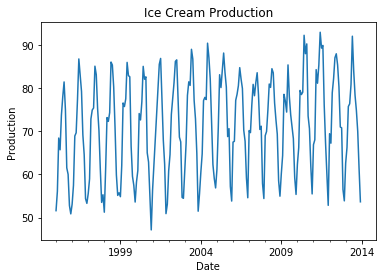

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
items = ["Cotagecheese.Prod", "Icecream.Prod", "Milk.Prod", "N.CA.Fat.Price"]
item = items[1]

def plot_column(column, df):
    if column not in df.columns:
        print("Please select a column in the dataframe.")
        return
    else:
        labels_dict = {"Cotagecheese.Prod": ["Cottage Cheese", "Production"],
         "Icecream.Prod" : ["Ice Cream", "Production"],
         "Milk.Prod":["Milk", "Production"], 
         "N.CA.Fat.Price": ["Fat", "Price"]}
        
        graph = df[column].plot(title = labels_dict[column][0]+ " " + labels_dict[column][1])
        graph.set_xlabel("Date")
        graph.set_ylabel(labels_dict[column][1])
        plt.show()
    return

plot_column(item, df)       

#### Histograms

Another common plot is a histogram. This is particularly useful for observing the distribution of the data, in particular if it is close to Gaussian. Currently none of the columns are very close to Gaussian, so there is no need to add a visual comparison, however later we can use seaborn's distplot function to make such a comparison.

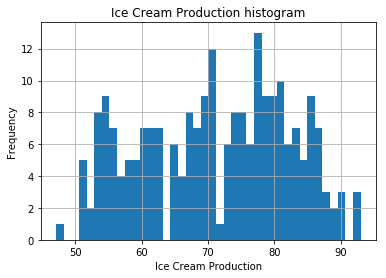

In [27]:
def hist_column(column, df):
    if column not in df.columns:
        print("Please select a column in the dataframe.")
        return
    else:
        labels_dict = {"Cotagecheese.Prod": ["Cottage Cheese", "Production"],
         "Icecream.Prod" : ["Ice Cream", "Production"],
         "Milk.Prod":["Milk", "Production"], 
         "N.CA.Fat.Price": ["Fat", "Price"]}
        
        graph = df[column].hist(bins = 40)
        plt.title(labels_dict[column][0]+ " " + labels_dict[column][1] + " histogram")
        graph.set_xlabel(labels_dict[column][0] + " " + labels_dict[column][1])
        graph.set_ylabel("Frequency")
        plt.show()
    return
hist_column(item, df)

#### Autocorrelation

Another useful plot specific to time series data are the autocorrelation and partial autocorrelation plots. 

The correlation is a statistical measure of how strongly related two random variables are. Given random variables $X, Y$ the (Pearson) correlation is the normalised covariance, that is

$Corr(X,Y) = \frac{Cov(X,Y)}{\sqrt{Var(X)Var(Y)}}. $

A time series can be thought of as a stochastic process, that is for each time $t$ in the series the data is a random variable $X_t$. We can consider the lagged time series $Y = L_\tau (X)$ where $Y_t = X_{t+\tau}$. Here $L_\tau$ is the lag-operator for $\tau$ lags. We can then compute the correlation between $Y$ and $X$, which is known as the autocorrelation with $\tau$ lags. 

The idea is that under certain circumstances (if the data follows an moving average (MA) model) the autocorrelation will drop off suddenly after a certain amount of lags $\tau$, implying that the time series at some time $t$ does not depend on the values at times $t-\tau$. For example any two times of a Gaussian white noise are independent, so the autocorrelation drops to 0 after just 1 lag (this is one condition under which we might say the time series is stationary). A standard Markov chain depends only on the previous value, and so it's autocorrelation should remain large at 1 lag, and drop off at 2 lags.

The autocorrelation plot plots the values of the autocorrelation of the time series for each number of lags. 

The partial autocorrelation is similar, except at each lag the the previous lags are accounted for. This is useful for determining the lags needed for an autoregressive (AR) model.

Below I use the acf and pacf functions of the statsmodels libraries to compute the autocorrelation and partial autocorrelation, along with confidence intervals for these values. 

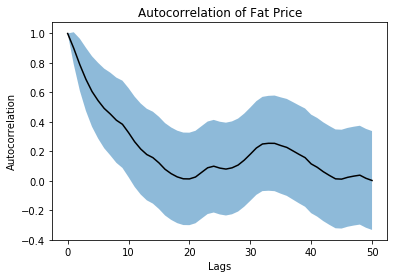

In [51]:
from statsmodels.tsa.stattools import acf, pacf

def autocorrelation_plot(column, df, partial = False, nlags=20, alpha = 0.1, transparency = 0.5):
    if column not in df.columns:
        print("Please select a column in the dataframe.")
        return
    else:
        labels_dict = {"Cotagecheese.Prod": ["Cottage Cheese", "Production"],
         "Icecream.Prod" : ["Ice Cream", "Production"],
         "Milk.Prod":["Milk", "Production"], 
         "N.CA.Fat.Price": ["Fat", "Price"]}
        title = "Autocorrelation of " + labels_dict[column][0] + " " + labels_dict[column][1]
        if(partial):
            bounds = pacf(df[item], nlags = nlags, alpha = alpha)
            title = "Partial "+title        
        else:
            bounds = acf(df[item], nlags = nlags, alpha = alpha)
        bounds_transpose = np.matrix.transpose(bounds[1])
        x = np.arange(0,nlags+1, 1)
        fig,ax = plt.subplots(1)
        ax.fill_between(x,bounds_transpose[0], bounds_transpose[1], alpha = transparency)
        ax.set_title(title)
        ax.set_xlabel("Lags")
        ax.set_ylabel("Autocorrelation")
        ax.plot(bounds[0], c = 'k')
        plt.show()
item = items[3]
autocorrelation_plot(item, df, nlags = 50, alpha = 0.1,partial=False)

Note that besides possibly the Fat price, the autocorrelation doesn't seem to drop off for any of the columns, suggesting a moving average model will not suffice for any of these.

### Trends
The trend of the data is the general pattern it follows. One way to formalise this is to take a moving average over some time frame, that is

$Y_t = \frac{1}{2\tau}\sum_{i = -\tau} ^\tau X_{t+i}$

where $\tau = 1, 2, \ldots$. 

This can be easily implemented using pandas rolling functions.

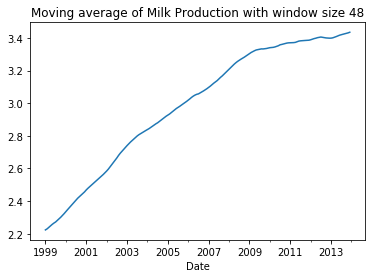

In [87]:
def get_moving_average(column, df, window_size =12, plot = False):
    if column not in df.columns:
        print("Please select a column in the dataframe.")
        return
    else:
        roll = df.rolling(window_size)
        trend = roll[column].mean()[window_size:]
        if(plot):
            labels_dict = {"Cotagecheese.Prod": ["Cottage Cheese", "Production"],
             "Icecream.Prod" : ["Ice Cream", "Production"],
             "Milk.Prod":["Milk", "Production"], 
             "N.CA.Fat.Price": ["Fat", "Price"]}
            title = "Moving average of " + labels_dict[column][0] + " " + labels_dict[column][1] + " with window size "+ str(window_size)
            trend.plot()
            plt.title(title)
            plt.show()
        return trend

item = items[2]
_ = get_moving_average(item, df, window_size = 48, plot=True)        

The larger the window size the more smooth, but less accurate the plot becomes. The idea here is to remove as much as the periodic behaviour as possible, and achieve a trend that is mostly linear. This is because we can then split the time series into 3 parts, a linear trend, a periodic but zero centred part, and a noise part. We can easily forecast the first two, and hope that the noise is sufficiently small. 

Another smoothing method is locally weighted scatterplot smoothing, LOESS or LOWESS for short. This is again implemented in the statsmodels library.

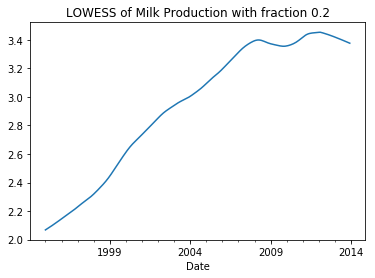

In [88]:
from statsmodels.nonparametric.smoothers_lowess import lowess
def get_lowess(column, df, frac =0.3, plot = False):
    if column not in df.columns:
        print("Please select a column in the dataframe.")
        return
    else:
        trend = lowess(df[column], np.arange(len(df)), frac = frac)
        trend = pd.Series(trend.T[1], index = df.index)
        if(plot):
            labels_dict = {"Cotagecheese.Prod": ["Cottage Cheese", "Production"],
             "Icecream.Prod" : ["Ice Cream", "Production"],
             "Milk.Prod":["Milk", "Production"], 
             "N.CA.Fat.Price": ["Fat", "Price"]}
            title = "LOWESS of " + labels_dict[column][0] + " " + labels_dict[column][1] + " with fraction "+ str(frac)
            trend.plot()
            plt.title(title)
            plt.show()
        return trend
_ = get_lowess(item,df, frac = 0.2, plot=True)

### Seasonal Trend

The seasonal trend is what remains after we remove one of the trends computed above. The hope is that this is a periodic pattern with mean zero, which we can model for the most part as some linear function of the time, modulo the length of the period. For example, if the pattern appears to be periodic with a pattern of about 12 months, we can use linear regression to find an appropriate prediction for each month. Note that we suppress the bias term as this would over-determine the model.

Note that below I have used the argument winfrac to stand for either window_size or the frac in the get_moving_average and get_lowess functions above. There is some minor error checking to make sure this is being used appropriately.

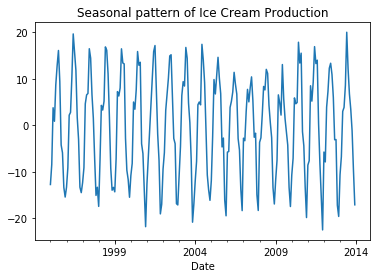

In [146]:
def get_seasonal(column, df, lowess=False, winfrac = 24, plot = False):
    if(lowess):
        if(winfrac > 1 or winfrac<0):
            print("Please set winfrac to be a fractional value.")
            return
        else:
            trend = get_lowess(column, df, frac = winfrac, plot=False)
            seasonal = df[column] - trend
    else:
        if not (isinstance(winfrac, int)):
            print("Please set winfrac to be an integer.")
            return
        else:
            trend = get_moving_average(column, df, window_size = winfrac, plot = False)
            seasonal = df[column][winfrac:] - trend
    if(plot):
        labels_dict = {"Cotagecheese.Prod": ["Cottage Cheese", "Production"],
                       "Icecream.Prod" : ["Ice Cream", "Production"],
                       "Milk.Prod":["Milk", "Production"],
                       "N.CA.Fat.Price": ["Fat", "Price"]}
        title = "Seasonal pattern of " + labels_dict[column][0] + " " + labels_dict[column][1]   
        seasonal.plot()
        plt.title(title)
        plt.xlabel("Date")
        plt.show()
    return seasonal

seasonal = get_seasonal(items[1], df, lowess=True, winfrac = 0.2, plot=True)

It is clear that the production values have mostly annual periodicity, as would be expected. Fat price is less clear. The Ice cream production is the most clearly seasonal, matching with the intuition that there would be a high and low throughout the year according to the season.

Below we use sklearn's linear model to get average values for the months so as to be able to approximate the seasonal pattern.

In [168]:
from sklearn.linear_model import LinearRegression
def model_seasonal(seasonal):
    months = seasonal.index.month
    features = pd.get_dummies(months)
    # reshape to fit sklearn models
    targets = np.reshape(seasonal.values, (-1,1))
    reg = LinearRegression(fit_intercept = False)
    reg.fit(features, targets)
    return reg

def predict(seasonal, reg):
    months = seasonal.index.month
    features = pd.get_dummies(months)
    predictions = reg.predict(features)
    predictions = pd.Series(predictions.T[0], index = seasonal.index)
    return predictions

def rmse(seasonal, reg):
    predictions = predict(seasonal, reg)
    error = np.sqrt(np.mean(np.square(seasonal.values-predictions.values)))
    return error


seasonal_train = seasonal[:150]
seasonal_valid = seasonal[150:]
reg = model_seasonal(seasonal_train)
print("Train error:", rmse(seasonal_train, reg))
print("Validation error:", rmse(seasonal_valid, reg))

Train error: 2.5334114605179323
Validation error: 3.1800304733159734


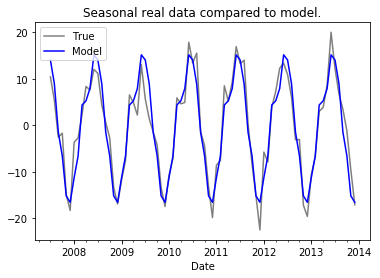

In [179]:
def plot_seasonal(seasonal, predictions):
    seasonal.plot(c = 'k', alpha = 0.5, label = "True")
    predictions.plot(c = 'b', label = "Model")
    plt.title("Seasonal real data compared to model.")
    plt.legend()
    plt.show()

plot_seasonal(seasonal_valid, predict(seasonal_valid, reg))